In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
!pip install diffusers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 32.7 MB/s eta 0:00:00


# Understanding Stable Diffusion - Devesh Surve

## Please take a look at the blog if you want to know more - https://deveshsurve.medium.com/

# Latent Diffusion Models: Theory and Algorithmic Steps

## Introduction

Latent Diffusion Models (LDMs) are a specific type of diffusion model optimized for generating high-quality images in a more memory-efficient manner by operating in a lower-dimensional latent space. Unlike traditional diffusion models that work directly on image pixels and consume considerable memory, LDMs achieve the diffusion process in latent space, significantly reducing the memory requirements. This process involves training the model to denoise random Gaussian noise step by step to eventually produce an image.

## Main Components

There are three main components in a latent diffusion model:

1. **CLIP Text Encoder**: Converts input text into text embeddings.
2. **Variational Auto Encoder (VAE)**: Compresses and decompresses images into and from a lower-dimensional latent space.
3. **U-Net**: Predicts the noise to be removed from the noised latent representations to reconstruct the original image data.

## CLIP Text Encoder

### Basics
The CLIP Text Encoder takes text as input and produces text embeddings. These embeddings represent the text in a form that is close in the latent space to the representation of images encoded by a similar process.

### Algorithmic Steps
1. **Tokenization**: Break down the input text into sub-words or tokens and convert these into numerical representations using a lookup table.
2. **Text to Embedding Conversion**: Utilize the CLIPTextModel to convert the numerical tokens into embeddings that encapsulate the semantic meaning of the text.

### Role in Latent Diffusion
The text embeddings generated by the CLIP Text Encoder are used as one of the inputs to the U-Net model. This enables the generation of images that are semantically related to the input text.

## Variational Auto Encoder (VAE)

### Basics
The VAE consists of two main parts: an encoder and a decoder. The encoder compresses an image into a lower-dimensional latent representation, and the decoder attempts to reconstruct the image from this latent representation.

### Algorithmic Steps
1. **Encoding**: Compress an input image into a latent space representation.
2. **Decoding**: Reconstruct the image from the latent representation.

### Role in Latent Diffusion
The VAE is essential for reducing the computational load of the diffusion process. By operating in latent space, the diffusion model requires less computational power and memory, facilitating the generation of high-resolution images.

## U-Net

### Basics
The U-Net architecture takes two inputs: noisy latents and text embeddings. It outputs the predicted noise residuals to be subtracted from the noisy latents, effectively denoising them.

### Algorithmic Steps
1. **Adding Noise**: Apply a series of noise levels to the latent representations according to a predetermined schedule.
2. **Noise Prediction**: For each noise level, predict the noise present in the noisy latents.
3. **Denoising**: Subtract the predicted noise from the noisy latents to move closer to the original image representation.

### Role in Latent Diffusion
The U-Net is crucial for the iterative denoising process in latent diffusion. By gradually reducing noise from the latents, it guides the generation process to produce images that correspond to the textual description provided.

## Conclusion

Latent diffusion models represent an advanced approach in the field of generative models, especially for tasks like image synthesis. By breaking down the process into distinct components like the CLIP Text Encoder, VAE, and U-Net, LDMs manage to efficiently generate high-quality images from textual descriptions.


# Importing Required Libaries

In [3]:
import torch, logging

## disable warnings
logging.disable(logging.WARNING)  

## Imaging  library
from PIL import Image
from torchvision import transforms as tfms

## Basic libraries
import numpy as np
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display
import shutil
import os

## For video display
from IPython.display import HTML
from base64 import b64encode


## Import the CLIP artifacts 
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderKL, UNet2DConditionModel, LMSDiscreteScheduler
from IPython.display import display, clear_output
import os

In [4]:
os.mkdir("/kaggle/working/steps2")

### Setting CPU/GPU device

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#### `load_image`

**Description:**

Loads an image from a specified path, converts it to RGB, and resizes it to a specified dimension.

**Parameters:**

- `p` (str): Path to the image file.
- `size` (tuple, optional): The dimensions to resize the image to. Default is `(512, 512)`.

**Returns:**

- `Image`: An image object in RGB format with the specified dimensions.

**Example Usage:**

```python
image = load_image("path/to/image.jpg", size=(512, 512))


In [6]:
## Helper functions
def load_image(p):
    '''
    Function to load images from a defined path
    '''
    return Image.open(p).convert('RGB').resize((512,512))



#### `pil_to_latents`

**Description:**

Converts a PIL image to a latent representation suitable for input into a VAE model.

**Parameters:**

- `image` (PIL.Image): The image to convert.

**Returns:**

- `Tensor`: The latent representation of the image.

**Example Usage:**

```python
latents = pil_to_latents(image)


In [7]:
def pil_to_latents(image):
    '''
    Function to convert image to latents
    '''
    init_image = tfms.ToTensor()(image).unsqueeze(0) * 2.0 - 1.0
    init_image = init_image.to(device="cuda", dtype=torch.float16) 
    init_latent_dist = vae.encode(init_image).latent_dist.sample() * 0.18215
    return init_latent_dist


#### `latents_to_pil`

**Description:**

Converts latents back into a PIL image, suitable for visualization and further processing.

**Parameters:**

- `latents` (Tensor): The latent representation to convert back to an image.

**Returns:**

- `List[Image]`: A list of image objects generated from the latent representations.

**Example Usage:**

```python
images = latents_to_pil(latents)
for img in images:
    img.show()


In [8]:
def latents_to_pil(latents):
    '''
    Function to convert latents to images
    '''
    latents = (1 / 0.18215) * latents
    with torch.no_grad():
        image = vae.decode(latents).sample
    image = (image / 2 + 0.5).clamp(0, 1)
    image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
    images = (image * 255).round().astype("uint8")
    pil_images = [Image.fromarray(image) for image in images]
    return pil_images


#### `text_enc`

**Description:**

Encodes textual prompts into embeddings using a CLIP text model.

**Parameters:**

- `prompts` (List[str]): A list of textual prompts to encode.
- `maxlen` (int, optional): Maximum length of the encoded text. Defaults to the model's maximum length.

**Returns:**

- `Tensor`: The encoded text embeddings.

**Example Usage:**

```python
embeddings = text_enc(["A clear blue sky", "The London Bridge"])


In [9]:

def text_enc(prompts, maxlen=None):
    '''
    A function to take a texual promt and convert it into embeddings
    '''
    if maxlen is None: maxlen = tokenizer.model_max_length
    inp = tokenizer(prompts, padding="max_length", max_length=maxlen, truncation=True, return_tensors="pt") 
    return text_encoder(inp.input_ids.to("cuda"))[0].half()


#### `prompt_2_img`

**Description:**

Converts text prompts into images using a latent diffusion model.

**Parameters:**

- `prompts` (List[str]): Text prompts to convert into images.
- `g` (float): Guidance scale. Higher values enforce stronger adherence to the text prompt.
- `seed` (int): Random seed for generating images.
- `steps` (int): Number of diffusion steps.
- `dim` (int): Dimension of the generated images.
- `save_int` (bool): Whether to save intermediate images.

**Returns:**

- `List[Image]`: A list of generated image objects corresponding to the text prompts.

**Example Usage:**

```python
images = prompt_2_img(["A sunset over a mountain range", "A cat playing with a ball"], g=7.5, seed=42, steps=100, dim=512, save_int=True)
for img in images:
    img.show()


In [10]:
def prompt_2_img(prompts, g=7.5, seed=100, steps=70, dim=512, save_int=True):
    """
    Diffusion process to convert prompt to image
    """
    
    # Defining batch size
    bs = len(prompts) 
    
    # Converting textual prompts to embedding
    text = text_enc(prompts) 
    
    # Adding an unconditional prompt , helps in the generation process
    uncond =  text_enc([""] * bs, text.shape[1])
    emb = torch.cat([uncond, text])
    
    # Setting the seed
    if seed: torch.manual_seed(seed)
    
    # Initiating random noise
    latents = torch.randn((bs, unet.in_channels, dim//8, dim//8))
    
    # Setting number of steps in scheduler
    scheduler.set_timesteps(steps)
    
    # Adding noise to the latents 
    latents = latents.to("cuda").half() * scheduler.init_noise_sigma

    print("Processing text prompts:", prompts)
    # Just before the loop starts:
    print("Visualizing initial latents...")
    latents_norm = torch.norm(latents.view(latents.shape[0], -1), dim=1).mean().item()
    print(f"Initial Latents Norm: {latents_norm}")

    # Iterating through defined steps
    for i,ts in enumerate(tqdm(scheduler.timesteps)):
        # We need to scale the i/p latents to match the variance
        inp = scheduler.scale_model_input(torch.cat([latents] * 2), ts)
        
        # Predicting noise residual using U-Net
        with torch.no_grad(): u,t = unet(inp, ts, encoder_hidden_states=emb).sample.chunk(2)
            
        # Performing Guidance
        pred = u + g*(t-u)
        
        # Conditioning  the latents
        latents = scheduler.step(pred, ts, latents).prev_sample
        
        # Inside your loop, after `latents` have been updated:
        latents_norm = torch.norm(latents.view(latents.shape[0], -1), dim=1).mean().item()
        print(f"Step {i+1}/{steps} Latents Norm: {latents_norm}")
        
        from IPython.display import display, clear_output
        if save_int and i%10==0: 
            image_path = f'steps2/la_{i:04d}.jpeg'
            latents_to_pil(latents)[0].save(image_path)
            display(latents_to_pil(latents)[0])  # Display the new image

    return latents_to_pil(latents)

# Overview — The Diffusion Process

- The stable diffusion model takes the textual input and a seed. 
- The textual input is then passed through the CLIP model to generate textual embedding of size 77x768 and the seed is used to generate Gaussian noise of size 4x64x64 which becomes the first latent image representation.
- Next, the U-Net iteratively denoises the random latent image representations while conditioning on the text embeddings. 
- The output of the U-Net is predicted noise residual, which is then used to compute conditioned latents via a scheduler algorithm. 
- This process of denoising and text conditioning is repeated N times (We will use 50) to retrieve a better latent image representation. 
- Once this process is complete, the latent image representation (4x64x64) is decoded by the VAE decoder to retrieve the final output image (3x512x512).



In [11]:

## Initiating tokenizer and encoder.
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14", torch_dtype=torch.float16)
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14", torch_dtype=torch.float16).to("cuda")

## Initiating the VAE
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae", torch_dtype=torch.float16).to("cuda")

## Initializing a scheduler and Setting number of sampling steps
scheduler = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000)
scheduler.set_timesteps(50)

## Initializing the U-Net model
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet", torch_dtype=torch.float16).to("cuda")


tokenizer_config.json:   0%|          | 0.00/905 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/961k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.52k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

vae/diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

unet/diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

Processing text prompts: ['A dog wearing a hat']
Visualizing initial latents...
Initial Latents Norm: 1878.0


/tmp/ipykernel_24/3935557845.py:20: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  latents = torch.randn((bs, unet.in_channels, dim//8, dim//8))


  0%|          | 0/70 [00:00<?, ?it/s]

Step 1/70 Latents Norm: 1722.0


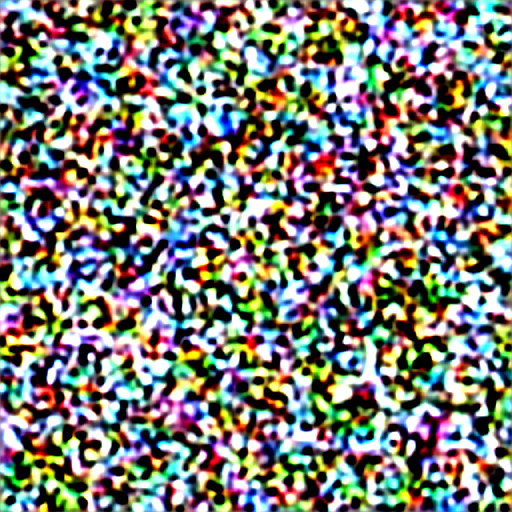

Step 2/70 Latents Norm: 1582.0
Step 3/70 Latents Norm: 1455.0
Step 4/70 Latents Norm: 1342.0
Step 5/70 Latents Norm: 1239.0
Step 6/70 Latents Norm: 1146.0
Step 7/70 Latents Norm: 1063.0
Step 8/70 Latents Norm: 986.0
Step 9/70 Latents Norm: 917.0
Step 10/70 Latents Norm: 854.5
Step 11/70 Latents Norm: 797.0


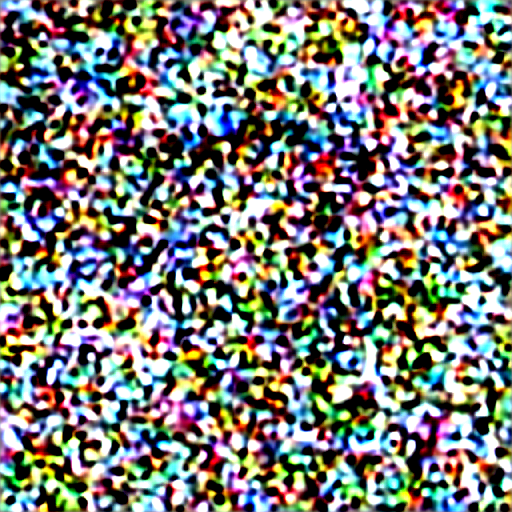

Step 12/70 Latents Norm: 745.0
Step 13/70 Latents Norm: 697.5
Step 14/70 Latents Norm: 654.0
Step 15/70 Latents Norm: 614.0
Step 16/70 Latents Norm: 577.5
Step 17/70 Latents Norm: 544.0
Step 18/70 Latents Norm: 513.0
Step 19/70 Latents Norm: 484.75
Step 20/70 Latents Norm: 458.5
Step 21/70 Latents Norm: 434.5


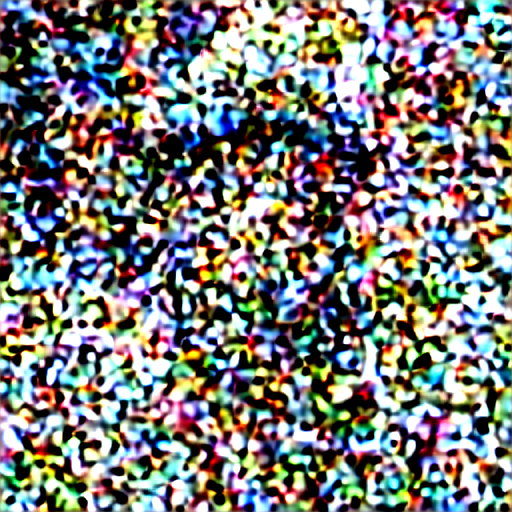

Step 22/70 Latents Norm: 412.0
Step 23/70 Latents Norm: 391.5
Step 24/70 Latents Norm: 372.25
Step 25/70 Latents Norm: 354.5
Step 26/70 Latents Norm: 338.25
Step 27/70 Latents Norm: 322.75
Step 28/70 Latents Norm: 308.75
Step 29/70 Latents Norm: 295.5
Step 30/70 Latents Norm: 283.25
Step 31/70 Latents Norm: 271.75


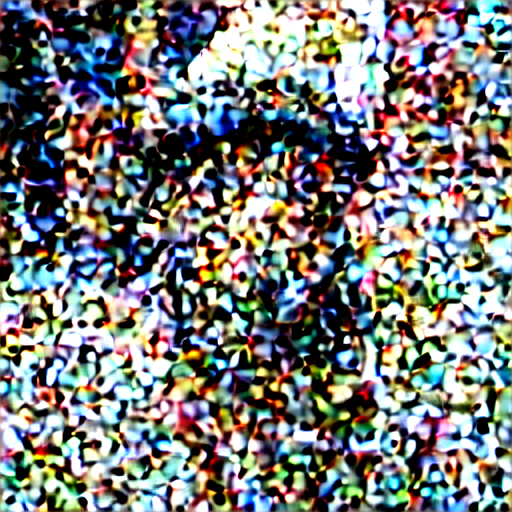

Step 32/70 Latents Norm: 261.0
Step 33/70 Latents Norm: 251.125
Step 34/70 Latents Norm: 241.75
Step 35/70 Latents Norm: 233.125
Step 36/70 Latents Norm: 224.875
Step 37/70 Latents Norm: 217.25
Step 38/70 Latents Norm: 210.125
Step 39/70 Latents Norm: 203.375
Step 40/70 Latents Norm: 197.125
Step 41/70 Latents Norm: 191.25


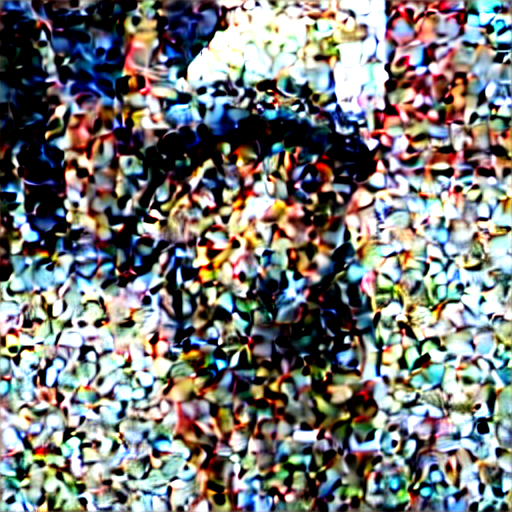

Step 42/70 Latents Norm: 185.625
Step 43/70 Latents Norm: 180.375
Step 44/70 Latents Norm: 175.5
Step 45/70 Latents Norm: 170.875
Step 46/70 Latents Norm: 166.625
Step 47/70 Latents Norm: 162.5
Step 48/70 Latents Norm: 158.75
Step 49/70 Latents Norm: 155.125
Step 50/70 Latents Norm: 151.75
Step 51/70 Latents Norm: 148.625


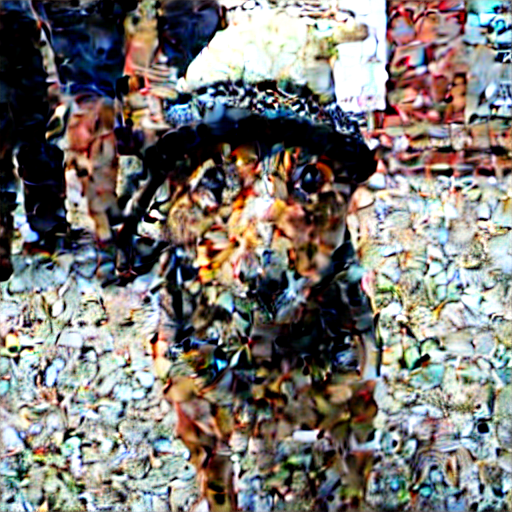

Step 52/70 Latents Norm: 145.625
Step 53/70 Latents Norm: 142.875
Step 54/70 Latents Norm: 140.25
Step 55/70 Latents Norm: 137.75
Step 56/70 Latents Norm: 135.5
Step 57/70 Latents Norm: 133.25
Step 58/70 Latents Norm: 131.25
Step 59/70 Latents Norm: 129.375
Step 60/70 Latents Norm: 127.625
Step 61/70 Latents Norm: 126.0


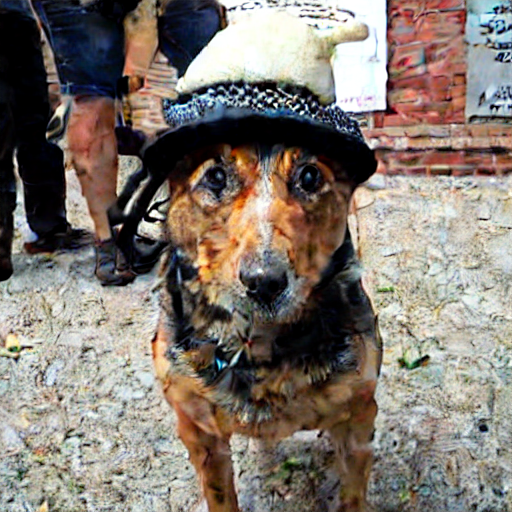

Step 62/70 Latents Norm: 124.4375
Step 63/70 Latents Norm: 123.0
Step 64/70 Latents Norm: 121.6875
Step 65/70 Latents Norm: 120.4375
Step 66/70 Latents Norm: 119.25
Step 67/70 Latents Norm: 118.1875
Step 68/70 Latents Norm: 117.25
Step 69/70 Latents Norm: 116.3125
Step 70/70 Latents Norm: 116.25


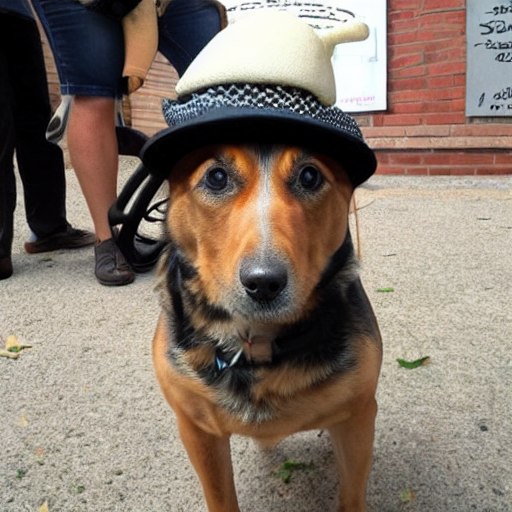

In [12]:
images = prompt_2_img(["A dog wearing a hat"], save_int=True)
for img in images:display(img)


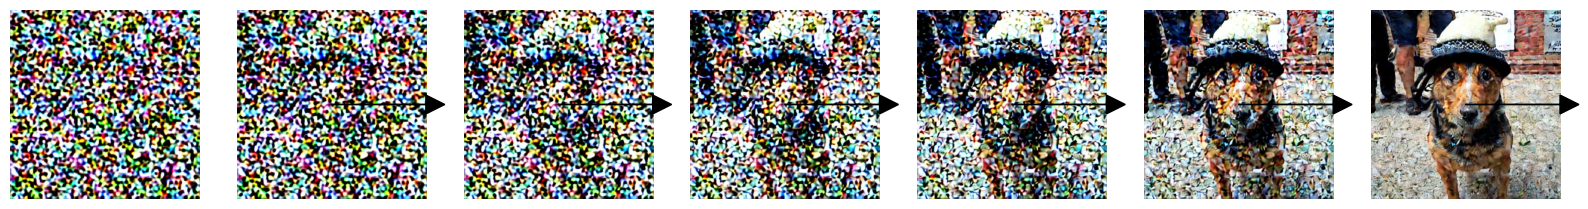

In [13]:
import os
import matplotlib.pyplot as plt

def visualize_steps(folder='/kaggle/working/steps2'):
    # Get list of all files in the folder
    files = os.listdir(folder)
    # Filter only image files
    image_files = [file for file in files if file.endswith('.jpeg')]
    num_steps = len(image_files)

    fig, axs = plt.subplots(1, num_steps, figsize=(20, 10))
    for ax, img_file in zip(axs, sorted(image_files)):  # Sort to ensure proper ordering
        img_path = os.path.join(folder, img_file)
        img = plt.imread(img_path)
        ax.imshow(img)
        ax.axis('off')  # Turn off axis numbering and ticks
        
        # Add arrows (except for the last image)
        if img_file != image_files[0]:
            ax.arrow(0.5, 0.5, 0.5, 0, head_width=0.1, head_length=0.1, fc='k', ec='k',transform=ax.transAxes, clip_on=False)

    plt.show()

# Call the function to display the visualization
visualize_steps()
